In [1]:
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         setup_multi_processes, update_data_root)

import wandb

In [2]:
cfg = Config.fromfile('./swin_faster_cfg.py')

cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset = build_dataset(cfg.data.train)
dataset

loading annotations into memory...
Done (t=3.31s)
creating index...
index created!



CocoDataset Train dataset with number of images 41820, and instance counts: 
+----------+--------+----------------+-------+--------------+-------+----------+-------+----------+-------+
| category | count  | category       | count | category     | count | category | count | category | count |
+----------+--------+----------------+-------+--------------+-------+----------+-------+----------+-------+
|          |        |                |       |              |       |          |       |          |       |
| 0 [선박] | 431471 | 1 [기타부유물] | 1773  | 2 [어망부표] | 20695 |          |       |          |       |
+----------+--------+----------------+-------+--------------+-------+----------+-------+----------+-------+

In [4]:
dataset.pipeline

Compose(
    LoadImageFromFile(to_float32=False, color_type='color', channel_order='bgr', file_client_args={'backend': 'disk'})
    LoadAnnotations(with_bbox=True, with_label=True, with_mask=False, with_seg=False, poly2mask=True, poly2mask={'backend': 'disk'})
    Resize(img_scale=[(768, 432)], multiscale_mode=range, ratio_range=None, keep_ratio=True, bbox_clip_border=True)
    RandomFlip(flip_ratio=0.0)
    Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True)
    Pad(size=None, size_divisor=32, pad_to_square=False, pad_val={'img': 0, 'masks': 0, 'seg': 255})
    DefaultFormatBundle(img_to_float=True)
    Collect(keys=['img', 'gt_bboxes', 'gt_labels'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))
)

In [5]:
import numpy as np

i = np.random.randint(0, len(dataset))
print(i)

dataset[i]

28920


{'img_metas': DataContainer({'filename': '../data/aihub/train/images/20201224/0615/PYS_SN_20201224_0615_0045.jpg', 'ori_filename': 'train/images/20201224/0615/PYS_SN_20201224_0615_0045.jpg', 'ori_shape': (2160, 3840, 3), 'img_shape': (432, 768, 3), 'pad_shape': (448, 768, 3), 'scale_factor': array([0.2, 0.2, 0.2, 0.2], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}),
 'img': DataContainer(tensor([[[0.4851, 0.4851, 0.4851,  ..., 0.4166, 0.4166, 0.4166],
          [0.4851, 0.4851, 0.4851,  ..., 0.4166, 0.4166, 0.4166],
          [0.4851, 0.4851, 0.5022,  ..., 0.4508, 0.4508, 0.4508],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6954, 0.6954, 0.6954,  ...

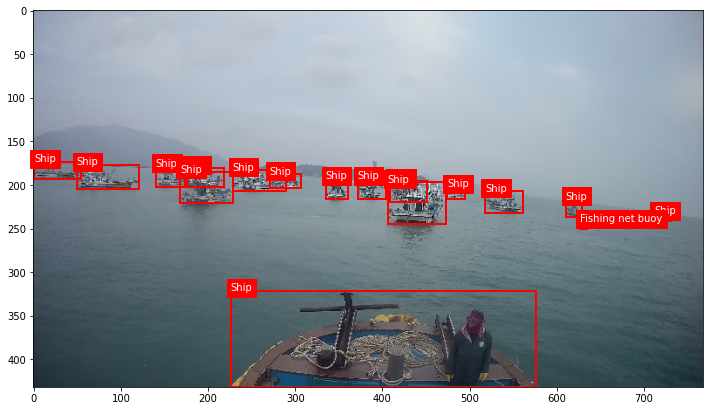

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

img = dataset[i]['img'].data.numpy()

min_ = np.min(img)
max_ = np.max(img)

img = img - (max_+min_)/2
img = img / (max_-min_)
img = img + 0.5

img = np.transpose(img, (1, 2, 0))
img = img[0:cfg.img_scale[1], 0:cfg.img_scale[0]]

classes = ("Ship", "General float", "Fishing net buoy")

fig, ax = plt.subplots(figsize=(12, 12))

for (l, t, r, b), c in zip(dataset[i]['gt_bboxes'].data, dataset[i]['gt_labels'].data):
    
    rect = mpl.patches.Rectangle((l, t), r-l, b-t, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    ax.text(x=l, y=t, s=classes[c], fontsize=10, color='white', backgroundcolor='red')

plt.imshow(img)
plt.show()

In [7]:
model = build_detector(cfg.model)
model.init_weights()

2022-05-27 18:38:43,290 - mmdet - INFO - load checkpoint from http path: https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth
2022-05-27 18:38:43,407 - mmdet - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-05-27 18:38:43,429 - mmdet - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-05-27 18:38:43,435 - mmdet - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-05-27 18:38:43,536 - mmcv - INFO - 
backbone.patch_embed.projection.weight - torch.Size([96, 3, 4, 4]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-05-27 18:38:43,537 - mmcv - INFO - 
backbo

In [8]:
train_detector(model, dataset, cfg, distributed=False, validate=True)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2022-05-27 18:38:47,961 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-05-27 18:38:48,271 - mmdet - INFO - Start running, host: root@4a37eb830c7b, work_dir: /opt/ml/mmdetection/work_dirs/all-seaing-eye
2022-05-27 18:38:48,272 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) I

Done (t=0.22s)
creating index...
index created!


wandb: Currently logged in as: jaeh8nkim. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.8/site-packages/mmcv/runner/hooks/optimizer.py:50: FutureWarning: Non-finite norm encountered in t

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.4 task/s, elapsed: 236s, ETA:     0s

2022-05-27 19:21:09,031 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=26.26s).
Accumulating evaluation results...


2022-05-27 19:21:38,869 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.403
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.69s).


2022-05-27 19:21:40,261 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_1.pth.
2022-05-27 19:21:40,261 - mmdet - INFO - Best bbox_mAP is 0.2580 at 1 epoch.
2022-05-27 19:21:40,267 - mmdet - INFO - Epoch(val) [1][5294]	bbox_mAP: 0.2580, bbox_mAP_50: 0.4030, bbox_mAP_75: 0.2620, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1170, bbox_mAP_l: 0.3630, bbox_mAP_copypaste: 0.258 0.403 0.262 0.000 0.117 0.363
2022-05-27 19:22:32,146 - mmdet - INFO - Epoch [2][50/2614]	lr: 1.000e-04, eta: 1 day, 7:13:38, time: 1.037, data_time: 0.154, memory: 12661, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0280, loss_cls: 0.1041, acc: 95.6145, loss_bbox: 0.2327, loss: 0.3709, grad_norm: 3.9239
2022-05-27 19:23:15,189 - mmdet - INFO - Epoch [2][100/2614]	lr: 1.000e-04, eta: 1 day, 7:12:13, time: 0.861, data_time: 0.023, memory: 12661, loss_rpn_cls: 0.0060, loss_rpn_bbox: 0.0282, loss_cls: 0.1078, acc: 95.4502, loss_bbox: 0.2382, loss: 0.3803, grad_norm: 4.2233
2022-05-27 19:23:58,515 - mmdet - INFO - Epo

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.3 task/s, elapsed: 237s, ETA:     0s

2022-05-27 20:03:31,151 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=24.26s).
Accumulating evaluation results...


2022-05-27 20:03:58,828 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.51s).


2022-05-27 20:04:00,326 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_2.pth.
2022-05-27 20:04:00,327 - mmdet - INFO - Best bbox_mAP is 0.2800 at 2 epoch.
2022-05-27 20:04:00,334 - mmdet - INFO - Epoch(val) [2][5294]	bbox_mAP: 0.2800, bbox_mAP_50: 0.4210, bbox_mAP_75: 0.3120, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1330, bbox_mAP_l: 0.4490, bbox_mAP_copypaste: 0.280 0.421 0.312 0.000 0.133 0.449
2022-05-27 20:04:51,603 - mmdet - INFO - Epoch [3][50/2614]	lr: 1.000e-04, eta: 1 day, 6:20:54, time: 1.025, data_time: 0.161, memory: 12661, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0243, loss_cls: 0.0864, acc: 96.3467, loss_bbox: 0.2009, loss: 0.3167, grad_norm: 2.7786
2022-05-27 20:05:34,429 - mmdet - INFO - Epoch [3][100/2614]	lr: 1.000e-04, eta: 1 day, 6:19:53, time: 0.857, data_time: 0.021, memory: 12661, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0240, loss_cls: 0.0848, acc: 96.4016, loss_bbox: 0.1989, loss: 0.3117, grad_norm: 3.5248
2022-05-27 20:06:17,502 - mmdet - INFO - Epo

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.3 task/s, elapsed: 237s, ETA:     0s

2022-05-27 20:45:48,052 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=23.17s).
Accumulating evaluation results...


2022-05-27 20:46:13,837 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.28s).


2022-05-27 20:46:15,293 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_3.pth.
2022-05-27 20:46:15,294 - mmdet - INFO - Best bbox_mAP is 0.3050 at 3 epoch.
2022-05-27 20:46:15,303 - mmdet - INFO - Epoch(val) [3][5294]	bbox_mAP: 0.3050, bbox_mAP_50: 0.4310, bbox_mAP_75: 0.3500, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1410, bbox_mAP_l: 0.5430, bbox_mAP_copypaste: 0.305 0.431 0.350 0.000 0.141 0.543
2022-05-27 20:47:06,696 - mmdet - INFO - Epoch [4][50/2614]	lr: 1.000e-04, eta: 1 day, 5:37:27, time: 1.028, data_time: 0.164, memory: 12661, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0226, loss_cls: 0.0786, acc: 96.7007, loss_bbox: 0.1840, loss: 0.2883, grad_norm: 2.4769
2022-05-27 20:47:50,145 - mmdet - INFO - Epoch [4][100/2614]	lr: 1.000e-04, eta: 1 day, 5:36:44, time: 0.869, data_time: 0.020, memory: 12661, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0218, loss_cls: 0.0770, acc: 96.7427, loss_bbox: 0.1827, loss: 0.2849, grad_norm: 2.8116
2022-05-27 20:48:33,482 - mmdet - INFO - Epo

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.1 task/s, elapsed: 240s, ETA:     0s

2022-05-27 21:28:06,824 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.73s).
Accumulating evaluation results...


2022-05-27 21:28:31,593 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.22s).


2022-05-27 21:29:22,628 - mmdet - INFO - Epoch [5][50/2614]	lr: 1.000e-04, eta: 1 day, 4:57:05, time: 1.018, data_time: 0.156, memory: 12662, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0196, loss_cls: 0.0666, acc: 97.1909, loss_bbox: 0.1668, loss: 0.2557, grad_norm: 2.7992
2022-05-27 21:30:05,724 - mmdet - INFO - Epoch [5][100/2614]	lr: 1.000e-04, eta: 1 day, 4:56:19, time: 0.862, data_time: 0.024, memory: 12662, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0211, loss_cls: 0.0687, acc: 97.0898, loss_bbox: 0.1740, loss: 0.2669, grad_norm: 2.5754
2022-05-27 21:30:48,312 - mmdet - INFO - Epoch [5][150/2614]	lr: 1.000e-04, eta: 1 day, 4:55:27, time: 0.852, data_time: 0.023, memory: 12662, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0204, loss_cls: 0.0683, acc: 97.1350, loss_bbox: 0.1670, loss: 0.2582, grad_norm: 2.4594
2022-05-27 21:31:32,082 - mmdet - INFO - Epoch [5][200/2614]	lr: 1.000e-04, eta: 1 day, 4:54:48, time: 0.875, data_time: 0.020, memory: 12662, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0200, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.3 task/s, elapsed: 237s, ETA:     0s

2022-05-27 22:10:19,574 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.65s).
Accumulating evaluation results...


2022-05-27 22:10:44,236 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.433
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.19s).


2022-05-27 22:11:35,533 - mmdet - INFO - Epoch [6][50/2614]	lr: 1.000e-04, eta: 1 day, 4:17:49, time: 1.023, data_time: 0.155, memory: 12662, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0199, loss_cls: 0.0655, acc: 97.2332, loss_bbox: 0.1611, loss: 0.2488, grad_norm: 2.4166
2022-05-27 22:12:19,107 - mmdet - INFO - Epoch [6][100/2614]	lr: 1.000e-04, eta: 1 day, 4:17:08, time: 0.871, data_time: 0.020, memory: 12662, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0198, loss_cls: 0.0658, acc: 97.2520, loss_bbox: 0.1614, loss: 0.2497, grad_norm: 2.6510
2022-05-27 22:13:02,636 - mmdet - INFO - Epoch [6][150/2614]	lr: 1.000e-04, eta: 1 day, 4:16:27, time: 0.871, data_time: 0.023, memory: 12662, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0196, loss_cls: 0.0636, acc: 97.3179, loss_bbox: 0.1593, loss: 0.2446, grad_norm: 2.6033
2022-05-27 22:13:46,160 - mmdet - INFO - Epoch [6][200/2614]	lr: 1.000e-04, eta: 1 day, 4:15:45, time: 0.870, data_time: 0.024, memory: 12662, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0189, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.6 task/s, elapsed: 234s, ETA:     0s

2022-05-27 22:52:30,983 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.57s).
Accumulating evaluation results...


2022-05-27 22:52:56,134 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.79s).


2022-05-27 22:52:57,640 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_6.pth.
2022-05-27 22:52:57,641 - mmdet - INFO - Best bbox_mAP is 0.3130 at 6 epoch.
2022-05-27 22:52:57,647 - mmdet - INFO - Epoch(val) [6][5294]	bbox_mAP: 0.3130, bbox_mAP_50: 0.4360, bbox_mAP_75: 0.3520, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1520, bbox_mAP_l: 0.5390, bbox_mAP_copypaste: 0.313 0.436 0.352 0.000 0.152 0.539
2022-05-27 22:53:48,270 - mmdet - INFO - Epoch [7][50/2614]	lr: 1.000e-04, eta: 1 day, 3:39:11, time: 1.012, data_time: 0.149, memory: 12662, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0184, loss_cls: 0.0599, acc: 97.4744, loss_bbox: 0.1495, loss: 0.2293, grad_norm: 2.6168
2022-05-27 22:54:31,287 - mmdet - INFO - Epoch [7][100/2614]	lr: 1.000e-04, eta: 1 day, 3:38:26, time: 0.860, data_time: 0.025, memory: 12662, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0181, loss_cls: 0.0611, acc: 97.4465, loss_bbox: 0.1502, loss: 0.2314, grad_norm: 2.2992
2022-05-27 22:55:14,359 - mmdet - INFO - Epo

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.4 task/s, elapsed: 237s, ETA:     0s

2022-05-27 23:34:51,003 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.14s).
Accumulating evaluation results...


2022-05-27 23:35:15,133 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.16s).


2022-05-27 23:35:16,636 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_7.pth.
2022-05-27 23:35:16,637 - mmdet - INFO - Best bbox_mAP is 0.3160 at 7 epoch.
2022-05-27 23:35:16,644 - mmdet - INFO - Epoch(val) [7][5294]	bbox_mAP: 0.3160, bbox_mAP_50: 0.4360, bbox_mAP_75: 0.3700, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1560, bbox_mAP_l: 0.5270, bbox_mAP_copypaste: 0.316 0.436 0.370 0.000 0.156 0.527
2022-05-27 23:36:08,210 - mmdet - INFO - Epoch [8][50/2614]	lr: 1.000e-04, eta: 1 day, 3:01:25, time: 1.031, data_time: 0.159, memory: 12662, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0171, loss_cls: 0.0571, acc: 97.6123, loss_bbox: 0.1424, loss: 0.2182, grad_norm: 2.4012
2022-05-27 23:36:51,931 - mmdet - INFO - Epoch [8][100/2614]	lr: 1.000e-04, eta: 1 day, 3:00:45, time: 0.874, data_time: 0.022, memory: 12662, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0173, loss_cls: 0.0574, acc: 97.5989, loss_bbox: 0.1425, loss: 0.2190, grad_norm: 2.8894
2022-05-27 23:37:35,661 - mmdet - INFO - Epo

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.4 task/s, elapsed: 237s, ETA:     0s

2022-05-28 00:17:08,619 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.87s).
Accumulating evaluation results...


2022-05-28 00:17:32,950 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.69s).


2022-05-28 00:18:24,488 - mmdet - INFO - Epoch [9][50/2614]	lr: 1.000e-05, eta: 1 day, 2:23:28, time: 1.028, data_time: 0.157, memory: 12662, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0169, loss_cls: 0.0565, acc: 97.6938, loss_bbox: 0.1385, loss: 0.2140, grad_norm: 1.7953
2022-05-28 00:19:08,287 - mmdet - INFO - Epoch [9][100/2614]	lr: 1.000e-05, eta: 1 day, 2:22:47, time: 0.876, data_time: 0.023, memory: 12662, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0165, loss_cls: 0.0553, acc: 97.7261, loss_bbox: 0.1380, loss: 0.2115, grad_norm: 1.6668
2022-05-28 00:19:51,549 - mmdet - INFO - Epoch [9][150/2614]	lr: 1.000e-05, eta: 1 day, 2:22:04, time: 0.865, data_time: 0.021, memory: 12662, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0165, loss_cls: 0.0527, acc: 97.7839, loss_bbox: 0.1376, loss: 0.2081, grad_norm: 1.6639
2022-05-28 00:20:35,314 - mmdet - INFO - Epoch [9][200/2614]	lr: 1.000e-05, eta: 1 day, 2:21:23, time: 0.875, data_time: 0.021, memory: 12662, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0163, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.5 task/s, elapsed: 235s, ETA:     0s

2022-05-28 00:59:22,297 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.26s).
Accumulating evaluation results...


2022-05-28 00:59:45,949 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.441
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-05-28 00:59:47,441 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_9.pth.
2022-05-28 00:59:47,443 - mmdet - INFO - Best bbox_mAP is 0.3300 at 9 epoch.
2022-05-28 00:59:47,449 - mmdet - INFO - Epoch(val) [9][5294]	bbox_mAP: 0.3300, bbox_mAP_50: 0.4410, bbox_mAP_75: 0.3850, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1620, bbox_mAP_l: 0.5980, bbox_mAP_copypaste: 0.330 0.441 0.385 0.000 0.162 0.598
2022-05-28 01:00:38,796 - mmdet - INFO - Epoch [10][50/2614]	lr: 1.000e-05, eta: 1 day, 1:45:28, time: 1.027, data_time: 0.155, memory: 12662, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0148, loss_cls: 0.0479, acc: 97.9949, loss_bbox: 0.1237, loss: 0.1877, grad_norm: 1.7254
2022-05-28 01:01:22,666 - mmdet - INFO - Epoch [10][100/2614]	lr: 1.000e-05, eta: 1 day, 1:44:48, time: 0.877, data_time: 0.028, memory: 12662, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0147, loss_cls: 0.0469, acc: 98.0552, loss_bbox: 0.1221, loss: 0.1847, grad_norm: 1.7314
2022-05-28 01:02:05,890 - mmdet - INFO - E

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.6 task/s, elapsed: 234s, ETA:     0s

2022-05-28 01:41:33,800 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.65s).
Accumulating evaluation results...


2022-05-28 01:41:57,913 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.67s).


2022-05-28 01:41:59,392 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_10.pth.
2022-05-28 01:41:59,393 - mmdet - INFO - Best bbox_mAP is 0.3330 at 10 epoch.
2022-05-28 01:41:59,402 - mmdet - INFO - Epoch(val) [10][5294]	bbox_mAP: 0.3330, bbox_mAP_50: 0.4430, bbox_mAP_75: 0.3900, bbox_mAP_s: 0.0000, bbox_mAP_m: 0.1610, bbox_mAP_l: 0.6110, bbox_mAP_copypaste: 0.333 0.443 0.390 0.000 0.161 0.611
2022-05-28 01:42:50,390 - mmdet - INFO - Epoch [11][50/2614]	lr: 1.000e-05, eta: 1 day, 1:07:24, time: 1.019, data_time: 0.156, memory: 12662, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0150, loss_cls: 0.0461, acc: 98.0789, loss_bbox: 0.1200, loss: 0.1822, grad_norm: 1.6639
2022-05-28 01:43:33,411 - mmdet - INFO - Epoch [11][100/2614]	lr: 1.000e-05, eta: 1 day, 1:06:40, time: 0.860, data_time: 0.023, memory: 12662, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0144, loss_cls: 0.0435, acc: 98.1689, loss_bbox: 0.1165, loss: 0.1754, grad_norm: 1.6774
2022-05-28 01:44:16,770 - mmdet - INFO 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 21.9 task/s, elapsed: 242s, ETA:     0s

2022-05-28 02:23:47,915 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=21.28s).
Accumulating evaluation results...


2022-05-28 02:24:11,576 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.08s).


2022-05-28 02:25:02,746 - mmdet - INFO - Epoch [12][50/2614]	lr: 1.000e-06, eta: 1 day, 0:29:08, time: 1.021, data_time: 0.157, memory: 12662, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0137, loss_cls: 0.0447, acc: 98.1436, loss_bbox: 0.1172, loss: 0.1765, grad_norm: 1.5654
2022-05-28 02:25:45,642 - mmdet - INFO - Epoch [12][100/2614]	lr: 1.000e-06, eta: 1 day, 0:28:23, time: 0.858, data_time: 0.022, memory: 12662, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0144, loss_cls: 0.0464, acc: 98.0635, loss_bbox: 0.1193, loss: 0.1813, grad_norm: 1.5703
2022-05-28 02:26:28,737 - mmdet - INFO - Epoch [12][150/2614]	lr: 1.000e-06, eta: 1 day, 0:27:39, time: 0.862, data_time: 0.024, memory: 12662, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0140, loss_cls: 0.0449, acc: 98.1282, loss_bbox: 0.1162, loss: 0.1764, grad_norm: 1.6555
2022-05-28 02:27:12,113 - mmdet - INFO - Epoch [12][200/2614]	lr: 1.000e-06, eta: 1 day, 0:26:56, time: 0.868, data_time: 0.021, memory: 12662, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.01

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.3 task/s, elapsed: 238s, ETA:     0s

2022-05-28 03:05:58,613 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.76s).
Accumulating evaluation results...


2022-05-28 03:06:22,217 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.08s).


2022-05-28 03:07:13,760 - mmdet - INFO - Epoch [13][50/2614]	lr: 1.000e-06, eta: 23:51:08, time: 1.028, data_time: 0.151, memory: 12662, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0145, loss_cls: 0.0447, acc: 98.1619, loss_bbox: 0.1167, loss: 0.1771, grad_norm: 1.6106
2022-05-28 03:07:56,817 - mmdet - INFO - Epoch [13][100/2614]	lr: 1.000e-06, eta: 23:50:24, time: 0.861, data_time: 0.020, memory: 12662, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0147, loss_cls: 0.0448, acc: 98.1426, loss_bbox: 0.1180, loss: 0.1784, grad_norm: 1.6532
2022-05-28 03:08:40,134 - mmdet - INFO - Epoch [13][150/2614]	lr: 1.000e-06, eta: 23:49:41, time: 0.866, data_time: 0.024, memory: 12662, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0140, loss_cls: 0.0441, acc: 98.1846, loss_bbox: 0.1167, loss: 0.1757, grad_norm: 1.5810
2022-05-28 03:09:24,270 - mmdet - INFO - Epoch [13][200/2614]	lr: 1.000e-06, eta: 23:49:00, time: 0.883, data_time: 0.019, memory: 12662, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0144, loss_cls: 0.0467, ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 22.3 task/s, elapsed: 238s, ETA:     0s

2022-05-28 03:48:12,999 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.67s).
Accumulating evaluation results...


2022-05-28 03:48:36,546 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.07s).


2022-05-28 03:49:28,184 - mmdet - INFO - Epoch [14][50/2614]	lr: 1.000e-06, eta: 23:13:20, time: 1.030, data_time: 0.161, memory: 12662, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0134, loss_cls: 0.0441, acc: 98.1965, loss_bbox: 0.1138, loss: 0.1725, grad_norm: 1.5913
2022-05-28 03:50:11,251 - mmdet - INFO - Epoch [14][100/2614]	lr: 1.000e-06, eta: 23:12:37, time: 0.861, data_time: 0.020, memory: 12662, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0141, loss_cls: 0.0432, acc: 98.1946, loss_bbox: 0.1137, loss: 0.1719, grad_norm: 1.5913
2022-05-28 03:50:55,100 - mmdet - INFO - Epoch [14][150/2614]	lr: 1.000e-06, eta: 23:11:55, time: 0.877, data_time: 0.027, memory: 12662, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0137, loss_cls: 0.0442, acc: 98.1665, loss_bbox: 0.1157, loss: 0.1747, grad_norm: 1.6396
2022-05-28 03:51:38,562 - mmdet - INFO - Epoch [14][200/2614]	lr: 1.000e-06, eta: 23:11:12, time: 0.869, data_time: 0.020, memory: 12662, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0144, loss_cls: 0.0464, ac

KeyboardInterrupt: 